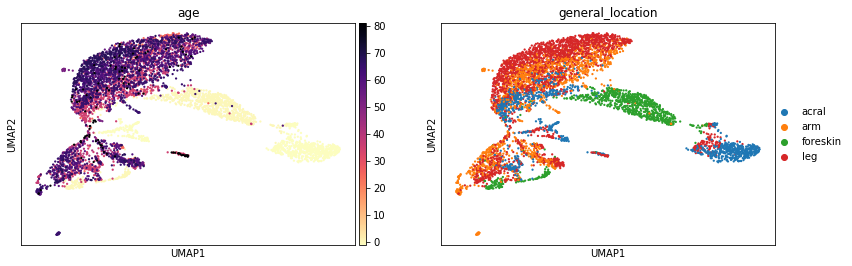

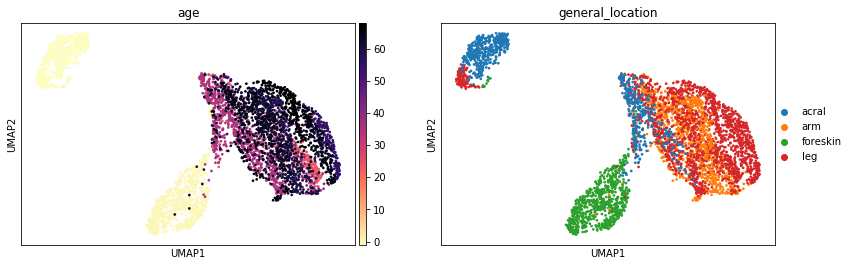

Completed


In [12]:
###############################################
###############################################
# Setup
# This chuck ingests pre-computed variables
###############################################
###############################################

# [Shift + Return] to run chunks 

###############################################

# settings
wkdir, s3dir = '/home/ubuntu/data/DL20181011_melanocyte_test_data', 'daniel.le-work/MEL_project'

%reload_ext autoreload
%autoreload 2
from scanpy_helpers import *
warnings.filterwarnings('ignore')
%matplotlib inline

# import data from s3
for file in ['adata_subset1', 'adata_subset2', 'full_adata', 'pre_adata','adata_subset1_KRT', 'raw_adata']:
#     ! aws s3 cp s3://{s3dir}/{file}.p {wkdir}/
    var = pickle.load((open(f'{wkdir}/{file}.p', 'rb')))
    exec(f'{file} = var')
    del var

# drop patients due to low cell count
adata_subset2_filtered = adata_subset2[[x not in ['A1015LM',
                                                'A1017LM',
                                                'A1012M'] for x in adata_subset2.obs.patient.tolist()]] 

# plot full data
sc.pl.umap(full_adata, color=['age','general_location'], cmap = 'magma_r')
sc.pl.umap(adata_subset2_filtered, color=['age','general_location'], cmap = 'magma_r')

print('Completed')


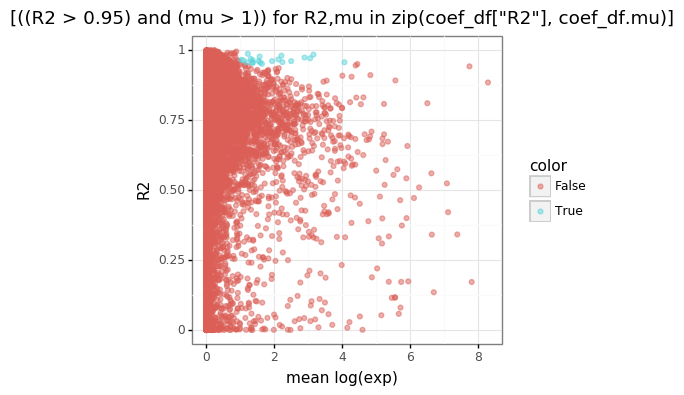

<ggplot: (-9223363244385343274)>
          gene         R      pval        mu        R2      1-R2  color
8319  SLC25A37  0.993230  0.006770  1.228888  0.986506  0.013494   True
6394       NOV  0.991725  0.008275  3.162110  0.983518  0.016482   True
7359    PRSS23 -0.989851  0.010149  2.219330  0.979806  0.020194   True
2652   FAM208A  0.988082  0.011918  1.577453  0.976306  0.023694   True
6246     NDRG2 -0.986394  0.013606  2.899423  0.972973  0.027027   True
3968       JUN  0.985112  0.014888  3.063512  0.970445  0.029555   True
3091     GCNT2  0.984100  0.015900  1.313282  0.968453  0.031547   True
3499     HIPK2  0.983002  0.016998  2.126900  0.966293  0.033707   True
5974      MPDZ  0.982308  0.017692  1.036662  0.964928  0.035072   True
2758    FBXO17  0.981492  0.018508  1.370244  0.963326  0.036674   True
3562     HLA-F -0.981258  0.018742  1.098423  0.962866  0.037134   True
9061     TEAD1  0.980203  0.019797  1.545086  0.960798  0.039202   True
1594   CLEC11A  0.980061  0.019

The protein encoded by this gene is a proton-linked monocarboxylate transporter that catalyzes the movement of many monocarboxylates, such as lactate and pyruvate, across the plasma membrane. Mutations in this gene are associated with erythrocyte lactate transporter defect. Alternatively spliced transcript variants have been found for this gene.[provided by RefSeq, Oct 2009].
19: SREK1
This gene encodes a member of a family of serine/arginine-rich (SR) splicing proteins containing RNA recognition motif (RRM) domains. The encoded protein interacts with other SR proteins to modulate splice site selection. Alternatively spliced transcript variants encoding multiple isoforms have been observed for this gene. [provided by RefSeq, Jul 2012].
20: C10orf32
N/A


In [13]:
###############################################
###############################################
# Gene-wise coefficient of variation vs age
# Returns correlation statistics and gene function annotations
###############################################
###############################################

# Specify age-binning: 'age_group' = 30-yr bins, 'age_bin' = 10-yr bins
groupby='age_group'

# Specify filtering criteria: min squared Pearson's correlation coefficient (R2) and min mean expression (mu)
R2 = 0.95
mu = 1

###############################################

groupby='age_group'
input_adata = adata_subset2_filtered

cat, df = prepare_dataframe(input_adata, 
                  var_names=input_adata.var_names,
                  groupby=groupby)

# coefficient of variation vs age bin
gene_std = df.groupby(groupby).std()
gene_mean = df.groupby(groupby).mean()
gene_coef = gene_std/gene_mean
gene_coef = gene_coef.reset_index()
gene_coef = (gene_coef
             .set_index(groupby)
             .sort_index())

r_list=[]
p_list=[]
mu_list=[]
for x in gene_coef.columns:
    r,p = pearsonr([x for x in range(gene_coef.shape[0])], 
                   gene_coef.loc[:, x])
    r_list.append(r)
    p_list.append(p)
    mu_list.append(df.loc[:,x].mean())
coef_df = pd.DataFrame({'gene':gene_coef.columns,
                         'R':r_list,
                         'pval':p_list,
                       'mu':mu_list})
coef_df['R2'] = coef_df['R']**2
coef_df['1-R2'] = 1-coef_df['R2']
condition_cmd = f'[((R2 > {R2}) and (mu > {mu})) for R2,mu in zip(coef_df["R2"], coef_df.mu)]'
condition_vec = eval(condition_cmd)
coef_df['color'] = condition_vec
coef_df = coef_df.sort_values('pval', ascending=True)
coef_df = coef_df.dropna()

# plot and print 
print(ggplot(coef_df)
      +theme_bw()
      +geom_point(aes('mu','R2', color = 'color'), alpha = 0.5)
      +ggtitle(condition_cmd)
      +labs(y = 'R2', x = 'mean log(exp)'))

print(coef_df[coef_df.color == True])

gene = coef_df[coef_df.color == True].gene
out = symbol2field(gene)
full_report = ['{}: {}\n{}'.format(idx,
                            x['query'],
                            x['summary']) if ('summary' in x.keys()) else '{}: {}\n{}'.format(idx,
                            x['query'],
                            'N/A') for idx, x in enumerate(out)]
search_term = ''
output = [print(x) for x in full_report if search_term in x]

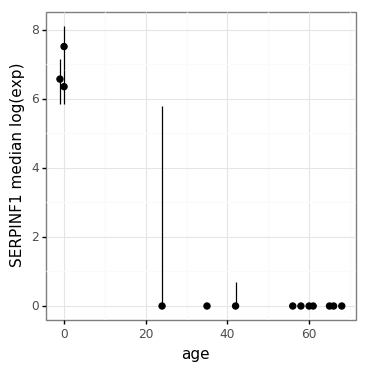

<ggplot: (8792465200455)>


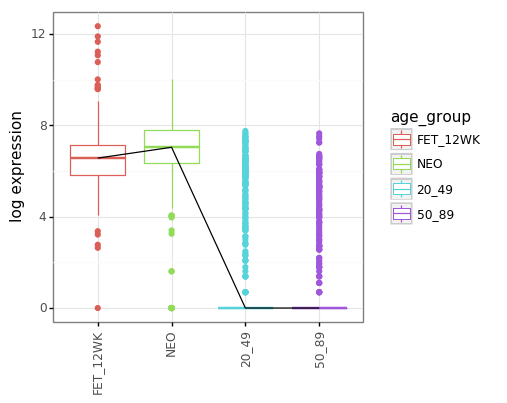

<ggplot: (8792425840367)>


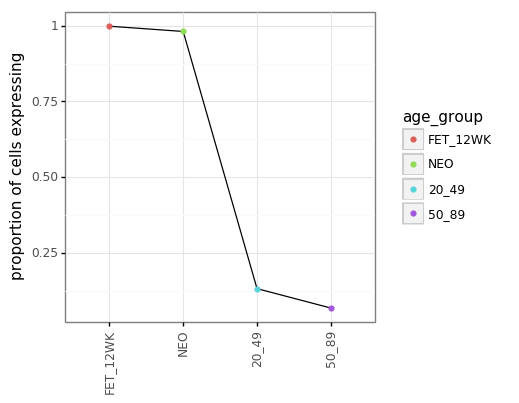

<ggplot: (8792465114895)>


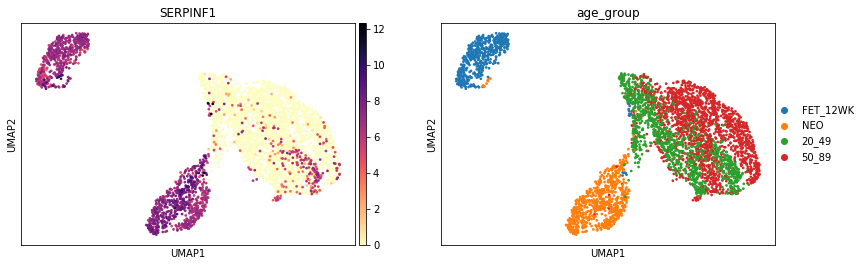

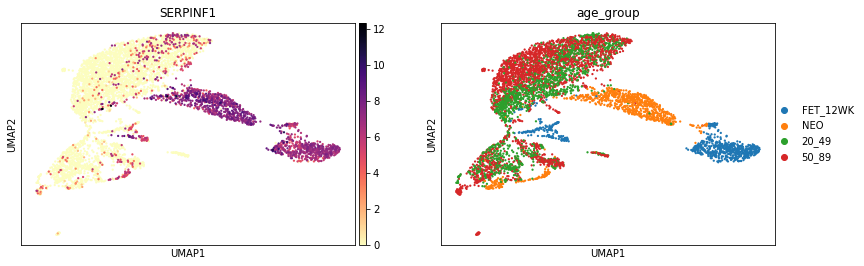

querying 1-1...done.
Finished.
0:  SERPINF1 
 This gene encodes a member of the serpin family that does not display the serine protease inhibitory activity shown by many of the other serpin proteins. The encoded protein is secreted and strongly inhibits angiogenesis. In addition, this protein is a neurotrophic factor involved in neuronal differentiation in retinoblastoma cells. Mutations in this gene were found in individuals with osteogenesis imperfecta, type VI. [provided by RefSeq, Aug 2016].


In [14]:
###############################################
###############################################
# Single-gene expression statistics
# Returns single-gene expression statistics as a function of true age
###############################################
###############################################

# Specify gene symbol
gene = 'SERPINF1'

# Specify age-binning: 'age_group' = 30-yr bins, 'age_bin' = 10-yr bins
groupby='age_group'

###############################################

# true age
true_age_exp(gene, input_adata)

# binned age
gene2plots(input_adata, gene, groupby)
sc.pl.umap(input_adata, color=[gene, groupby], cmap='magma_r')
sc.pl.umap(full_adata, color=[gene, groupby], cmap='magma_r')

out = symbol2field(gene)
output = [print(f'{idx}: ', 
       x['query'],
       '\n',x['summary']) if ('summary' in x.keys()) else print(f'{idx}: ', 
                                                                x['query'],
                                                                '\n','N/A') for idx, x in enumerate(out)]
